In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np

np.random.seed(42)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOTask,
    EOPatch,
    EOWorkflow,
    linearly_connect_tasks,
    FeatureType,
    OverwritePermission,
    LoadTask,
    SaveTask,
    EOExecutor,
    MergeFeatureTask,
)
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiffTask
from eolearn.geometry import VectorToRasterTask, ErosionTask
from eolearn.features import LinearInterpolationTask, SimpleFilterTask, NormalizedDifferenceIndexTask
from eolearn.ml_tools import FractionSamplingTask
from sentinelhub import UtmZoneSplitter, DataCollection
from sentinelhub import SHConfig
config = SHConfig()

from configparser import RawConfigParser 
parser=RawConfigParser()
parser.read(r'C:\Users\jegom\Desktop\PLUS\SD\A3\notebook.cfg')

config.instance_id = parser['sentinelhub']['instance_id']
config.sh_client_id = parser['sentinelhub']['sh_client_id']
config.sh_client_secret = parser['sentinelhub']['sh_client_secret']

import requests

url = "http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/land_use_10class_reference_slovenia_partial.gpkg"


c:\Users\jegom\Anaconda3\envs\A3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch
class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


Dimension of the area is 359609 x 234846 m2


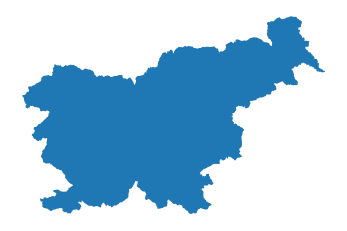

In [3]:
# Folder where data for running the notebook is stored
DATA_FOLDER = r'C:\Users\jegom\Desktop\PLUS\SD\A3'
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(DATA_FOLDER, "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(DATA_FOLDER, "eopatches_sampled")
RESULTS_FOLDER = os.path.join(DATA_FOLDER, "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "SV.geojson"))
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

# Plot country
country.plot()
plt.axis("off")

# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

In [4]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 422

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = "grid_slovenia_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")


c:\Users\jegom\Anaconda3\envs\A3\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


(357250.0, 637750.0, 5016500.0, 5203500.0)

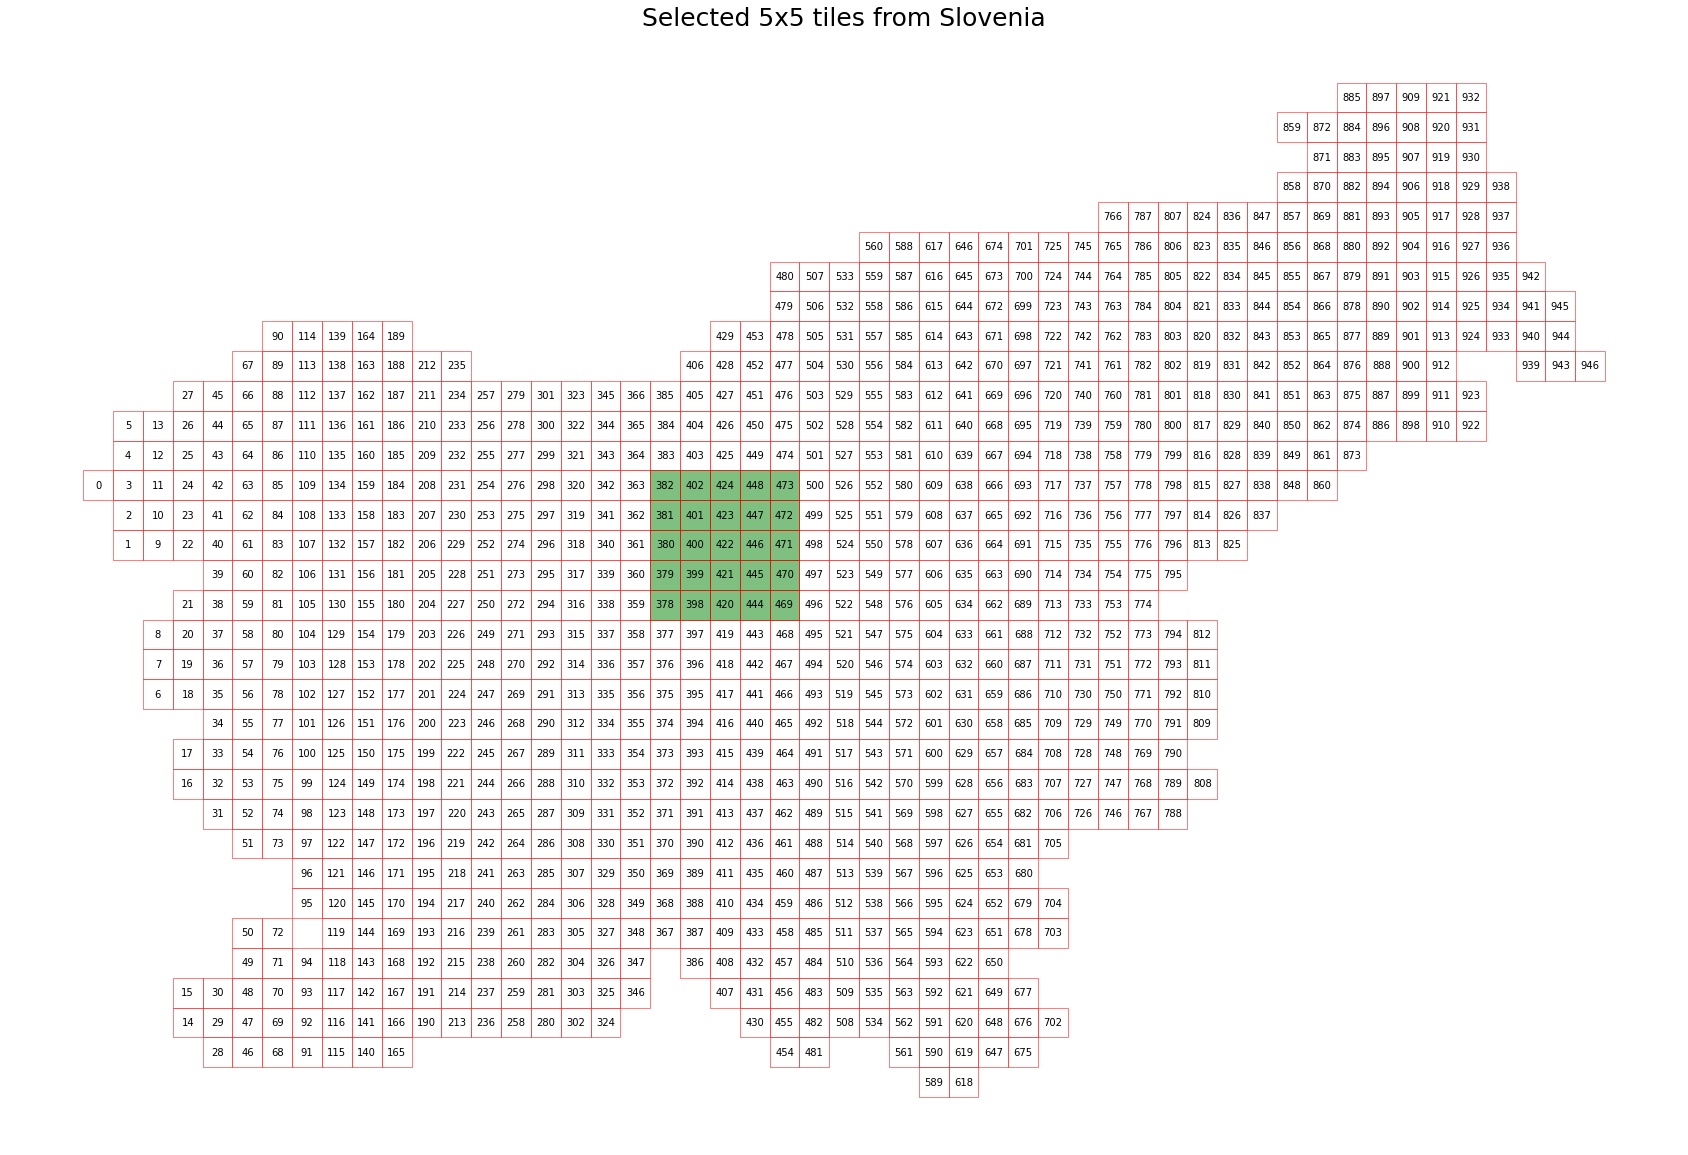

In [5]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title("Selected 5x5 tiles from Slovenia", fontsize=25)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

bbox_gdf[bbox_gdf.index.isin(patchIDs)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off")

In [6]:
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)

save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)



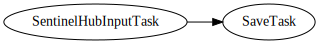

In [10]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data,save)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [11]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

100%|██████████| 25/25 [20:48<00:00, 49.92s/it]


CPU times: total: 219 ms
Wall time: 20min 48s


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


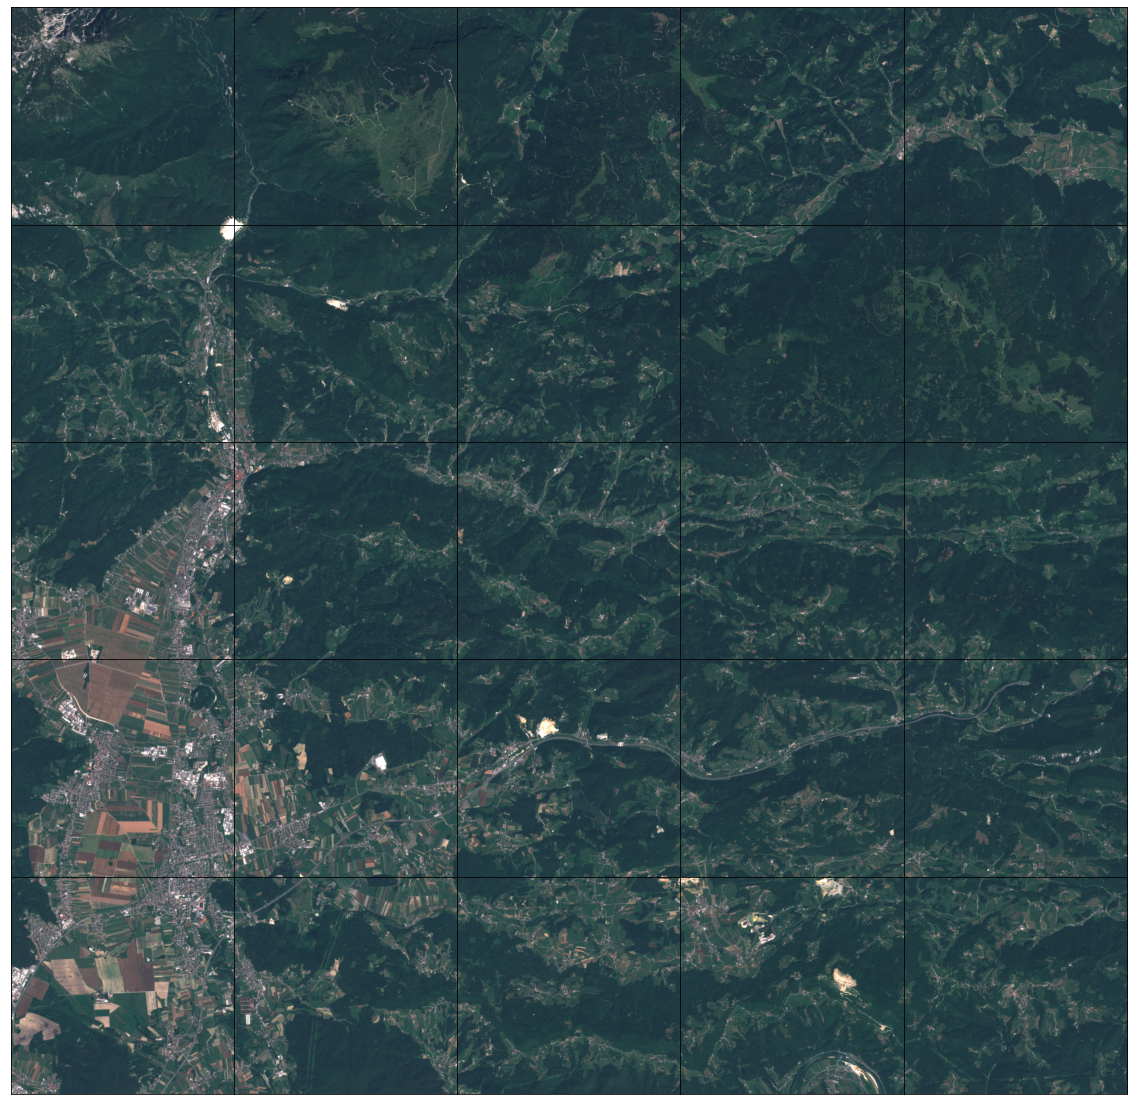

In [13]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019, 7, 1)

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamp])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)